# Constructing the Default Features
The functions used in the features module will be tested and demonstarted on the raw ADAEUR data to construct the default featurs of the data set.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from src.data import build_dataset as bd
from src.features import mass_features as mf
from src.features import build_features as bf

In [2]:
data = pd.read_pickle(r'\crypto_forecast\data\raw\ADAEUR_raw_2019_03.pkl')
hour_data = bd.sampleBars(data, method='time bars',interval='H')

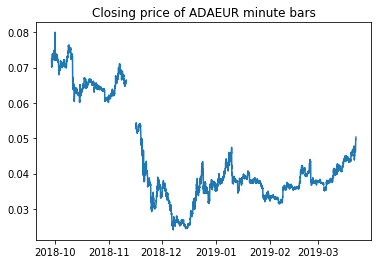

In [3]:
plt.plot(hour_data.close[10:])
plt.title('Closing price of ADAEUR minute bars');

Before constructing the features the first step is to split the data (which should have been done before sampling if not usng time bars) into two datasets. One before and one after the break in the data as can been seen in the above plot. If this is not done then the computations of the rolling everages and returns will be wrong. An alternative method may be to forward/back fill or fill the data by other means. The first 100 data bars will also be ingored as they do not contain useful information.

In [4]:
hour_data = hour_data[10:]
hour_data1 = hour_data[:'2018-11-11']
hour_data1 = hour_data1.dropna()
hour_data2 = hour_data['2018-11-11':]
hour_data2 = hour_data2.dropna()

The getMassFeatures() functions creates a bunch of derives features from the original bar data and returns a full feature df. There are 286 features in total.

In [5]:
hour_data11 = mf.getMassFeatures(hour_data1)
hour_data22 = mf.getMassFeatures(hour_data2)

In [7]:
hour_data11.to_pickle('ADAEUR_hour_data1.pkl')
hour_data22.to_pickle('ADAEUR_hour_data2.pkl')

# Making the Features Stationary
The functions from the build_features module can be used to fractionally differeniate any non-stationary features  to make them more stationary.

First we test each feature using the Augmented Dicky-Fuller test to test for stationarity using the significance at 0.001 given the amount of (almost 300) features. The features deemed non-stationary will then be fractionally differentiated using different values of d. The new diff-feature will then be tested using the ADF test again for each d and the lowest d that has p-value < 0.001 will be used.

In [68]:
# combine the data and test each feature column for stationarity using ADFuller tester with 1% conf.
from statsmodels.tsa.stattools import adfuller

df = hour_data11.append(hour_data22)
df_p=pd.DataFrame(index=['p-value'],columns=df.columns)
non_st=[]
for col in df.columns:
    df_p.loc['p-value',col]=adfuller(df[col].replace([np.inf, -np.inf], np.nan).dropna(),maxlag=1)[1]

C:\Users\luciu\Anaconda3\envs\crypto_env\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [103]:
non_st = df_p[df_p>0.001]
a=non_st.dropna(axis=1)
non_stationary_features = list(a.columns)
st = df_p[df_p<0.001]
b=st.dropna(axis=1)
stationary_features = list(b.columns)

In [104]:
non_stationary_features

['wavg',
 'open',
 'high',
 'low',
 'close',
 'logopen',
 'loghigh',
 'loglow',
 'logclose',
 'logwavg',
 '200_1dclose',
 '500_1dclose',
 '200_1dwavg',
 '500_1dwavg',
 '200_2dclose',
 '500_2dclose',
 '200_2dwavg',
 '500_2dwavg',
 'sma5',
 'smah5',
 'smal5',
 'sma10',
 'smah10',
 'smal10',
 'sma20',
 'smah20',
 'smal20',
 'sma50',
 'smah50',
 'smal50',
 'sma100',
 'smah100',
 'smal100',
 'sma200',
 'smah200',
 'smal200',
 'sma500',
 'smah500',
 'smal500',
 'sma2400',
 'smah2400',
 'smal2400',
 'logsma5',
 'logsmah5',
 'logsmal5',
 'logsma10',
 'logsmah10',
 'logsmal10',
 'logsma20',
 'logsmah20',
 'logsmal20',
 'logsma50',
 'logsmah50',
 'logsmal50',
 'logsma100',
 'logsmah100',
 'logsmal100',
 'logsma200',
 'logsmah200',
 'logsmal200',
 'logsma500',
 'logsmah500',
 'logsmal500',
 'logsma2400',
 'logsmah2400',
 'logsmal2400',
 'std50',
 'std100',
 'std200',
 'std500',
 'std1000',
 'std2400',
 'atr50',
 'atr100',
 'logatr50',
 'logatr100',
 'dvol',
 'dvolh',
 'dvoll',
 'dvolwavg',
 'cci5

In [105]:
df01 = pd.DataFrame(hour_data22)
df01 = df01[non_stationary_features]
df02 = pd.DataFrame(hour_data22)
df02 = df02[non_stationary_features]

In [106]:
out=pd.DataFrame(index=non_stationary_features,columns=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

for d in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]:
    # fracdiff the series
    df1= bf.fracDiff_FFD(df01,d,thres=0.01)
    df2= bf.fracDiff_FFD(df02,d,thres=0.01)
    df3 = df1.append(df2)
    
    for ft in non_stationary_features:
        # perform adfuller test on each fracdiff-feature
        adf=adfuller(df3[ft].replace([np.inf, -np.inf], np.nan).dropna(),maxlag=1,regression='c',autolag=None)
        out.loc[ft][d]=adf[1] # p-value

In [108]:
out.to_pickle('d_values_for_ADAEUR.pkl')